In [1]:

# === Cell 1: Imports & Paths ===
import os, cv2, numpy as np
from pathlib import Path
from collections import Counter
from typing import Tuple
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix
)
import joblib

# Root of your dataset
ROOT = Path("/u01/lcy/9517/dataset")

SPLITS = {
    "train": {"images": ROOT/"train/images", "labels": ROOT/"train/labels"},
    "valid": {"images": ROOT/"valid/images", "labels": ROOT/"valid/labels"},
    "test" : {"images": ROOT/"test/images" , "labels": ROOT/"test/labels" },
}

# Class names (12 classes)
NAMES = ["ants","bees","beetles","caterpillars","earthworms","earwigs",
         "grasshoppers","moths","slugs","snails","wasps","weevils"]

# Save directory for models
SAVE_DIR = Path("/u01/lcy/9517/exp_cls")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

print("Dataset root:", ROOT)
print("Save dir    :", SAVE_DIR)


Dataset root: /u01/lcy/9517/dataset
Save dir    : /u01/lcy/9517/exp_cls


In [2]:

# === Cell 2: Feature Extractors (HOG + Color Histogram) ===
hog = cv2.HOGDescriptor(_winSize=(128,128),
                        _blockSize=(16,16),
                        _blockStride=(8,8),
                        _cellSize=(8,8),
                        _nbins=9)

def feat_hog(img: np.ndarray) -> np.ndarray:
    img = cv2.resize(img, (128,128))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return hog.compute(gray).flatten()

def feat_color(img: np.ndarray, bins=(16,16,16)) -> np.ndarray:
    img = cv2.resize(img, (128,128))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv],[0,1,2],None,bins,[0,180,0,256,0,256]).flatten()
    return hist / (hist.sum() + 1e-8)

def extract_feature(img: np.ndarray) -> np.ndarray:
    # Concatenate HOG + HSV color histogram
    return np.concatenate([feat_hog(img), feat_color(img)], axis=0)


In [3]:

# === Cell 3: IO Helpers ===
IMG_EXTS = [".jpg",".jpeg",".png",".JPG",".PNG",".JPEG"]

def find_image_for(stem: str, img_dir: Path):
    for ext in IMG_EXTS:
        p = img_dir / f"{stem}{ext}"
        if p.exists():
            return p
    return None

def parse_label_file(txt_path: Path):
    """
    Read YOLO .txt (possibly multiple lines, multiple objects).
    Use the most frequent class id as the image label.
    """
    c = Counter()
    with open(txt_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line: 
                continue
            parts = line.split()
            cls_id = int(float(parts[0]))
            c[cls_id] += 1
    if not c:
        return None
    return c.most_common(1)[0][0]

def load_split(split_name: str):
    img_dir = SPLITS[split_name]["images"]
    lab_dir = SPLITS[split_name]["labels"]

    X_, y_ = [], []
    counts = Counter()

    if not lab_dir.exists():
        print(f"[WARN] Labels dir missing for split '{split_name}': {lab_dir}")
        return np.zeros((0,)), np.zeros((0,)), counts

    txt_files = sorted(lab_dir.glob("*.txt"))
    for txt in txt_files:
        stem = txt.stem
        img_path = find_image_for(stem, img_dir)
        if img_path is None:
            continue

        cid = parse_label_file(txt)
        if cid is None:
            continue

        img = cv2.imread(str(img_path))
        if img is None:
            continue

        X_.append(extract_feature(img))
        y_.append(cid)
        counts[cid] += 1

    if len(X_) == 0:
        print(f"[WARN] No samples found in split '{split_name}'.")
        return np.zeros((0,)), np.zeros((0,)), counts

    X_ = np.asarray(X_, dtype=np.float32)
    y_ = np.asarray(y_, dtype=np.int64)
    return X_, y_, counts


In [4]:

# === Cell 4: Metrics Helper ===
def summarize(y_true, y_pred, title, names=NAMES):
    acc = accuracy_score(y_true, y_pred)
    p = precision_score(y_true, y_pred, average='macro', zero_division=0)
    r = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    print(f"\n=== {title} ===")
    print(f"Accuracy: {acc:.4f} | Macro-P: {p:.4f} | Macro-R: {r:.4f} | Macro-F1: {f1:.4f}")
    labels_in_eval = sorted(np.unique(np.concatenate([y_true, y_pred])))
    names_in_eval = [names[i] for i in labels_in_eval]
    print(classification_report(y_true, y_pred, labels=labels_in_eval, target_names=names_in_eval, digits=3))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred, labels=labels_in_eval))
    return {"acc": acc, "macro_f1": f1}


In [ ]:

# === Cell 5: Load Data (train, valid, test) ===
Xtr, ytr, cnt_tr = load_split("train")
print("Train samples:", len(ytr))
for i, n in enumerate(NAMES):
    if cnt_tr[i] > 0:
        print(f"  [train] {i:02d} {n:14s}: {cnt_tr[i]}")

Xval, yval, cnt_val = load_split("valid")
if len(yval) == 0:
    print("[INFO] No explicit 'valid' split found; creating 80/20 split from train as internal validation.")
    Xtr, Xval, ytr, yval = train_test_split(
        Xtr, ytr, test_size=0.2, random_state=42, stratify=ytr
    )
else:
    print("Valid samples:", len(yval))
    for i, n in enumerate(NAMES):
        if cnt_val[i] > 0:
            print(f"  [valid] {i:02d} {n:14s}: {cnt_val[i]}")

Xte, yte, cnt_te = load_split("test")
print("Test samples :", len(yte))
for i, n in enumerate(NAMES):
    if cnt_te[i] > 0:
        print(f"  [test ] {i:02d} {n:14s}: {cnt_te[i]}")

if len(ytr) == 0 or len(yte) == 0:
    raise RuntimeError("Train or Test split is empty—please check dataset paths/labels.")


In [6]:

# === Cell 6: Define Models (Linear SVM & RBF SVM) ===
clf_lin = make_pipeline(
    StandardScaler(with_mean=False),
    LinearSVC(max_iter=20000, class_weight="balanced")
)

clf_rbf = make_pipeline(
    StandardScaler(with_mean=False),
    SVC(kernel="rbf", C=4.0, gamma="scale", class_weight="balanced")
)
print("Models ready: LinearSVC and RBF SVC")


Models ready: LinearSVC and RBF SVC


In [7]:

# === Cell 7: Train on TRAIN only ===
print("[Train] Fitting Linear SVM on TRAIN only...")
clf_lin.fit(Xtr, ytr)

print("[Train] Fitting RBF SVM on TRAIN only...")
clf_rbf.fit(Xtr, ytr)

print("Training complete.")


[Train] Fitting Linear SVM on TRAIN only...
[Train] Fitting RBF SVM on TRAIN only...
Training complete.


In [8]:
# === Cell 8: Evaluate on VALID ===
from sklearn.metrics import f1_score

print("[Validate] Evaluating models on VALID...")

yp_lin_val = clf_lin.predict(Xval)
summarize(yval, yp_lin_val, "Linear SVM (VALID)")
f1_lin = f1_score(yval, yp_lin_val, average='macro', zero_division=0)

yp_rbf_val = clf_rbf.predict(Xval)
summarize(yval, yp_rbf_val, "RBF SVM (VALID)")
f1_rbf = f1_score(yval, yp_rbf_val, average='macro', zero_division=0)

print(f"\n[Validate] macro-F1 -> linear: {f1_lin:.4f} | rbf: {f1_rbf:.4f}")


[Validate] Evaluating models on VALID...

=== Linear SVM (VALID) ===
Accuracy: 0.2274 | Macro-P: 0.2267 | Macro-R: 0.2218 | Macro-F1: 0.2228
              precision    recall  f1-score   support

        ants      0.189     0.240     0.211        96
        bees      0.379     0.333     0.355        99
     beetles      0.174     0.182     0.178        88
caterpillars      0.057     0.065     0.061        77
  earthworms      0.145     0.196     0.167        51
     earwigs      0.138     0.132     0.135        91
grasshoppers      0.162     0.173     0.167        98
       moths      0.465     0.400     0.430       100
       slugs      0.200     0.182     0.190        77
      snails      0.315     0.347     0.330        98
       wasps      0.239     0.181     0.206       116
     weevils      0.258     0.231     0.244       104

    accuracy                          0.227      1095
   macro avg      0.227     0.222     0.223      1095
weighted avg      0.236     0.227     0.230    

In [9]:
# === Cell 9: Select best on VALID & Save ===
import joblib
from pathlib import Path

best_name, best_model = ("linear_svm", clf_lin) if f1_lin >= f1_rbf else ("rbf_svm", clf_rbf)
print(f"[Model Selection] Best on VALID: {best_name}")

save_dir = Path("/u01/lcy/9517/exp_cls")
save_dir.mkdir(parents=True, exist_ok=True)
save_path = save_dir / f"traditional_{best_name}.joblib"
joblib.dump(best_model, str(save_path))
print(f"Model Saved to: {save_path}")


[Model Selection] Best on VALID: rbf_svm
Model Saved to: /u01/lcy/9517/exp_cls/traditional_rbf_svm.joblib


In [10]:
# === Cell 10: Final evaluation on TEST ===
yp_test = best_model.predict(Xte)
summarize(yte, yp_test, f"Best Model ({best_name}) on TEST")



=== Best Model (rbf_svm) on TEST ===
Accuracy: 0.3370 | Macro-P: 0.3415 | Macro-R: 0.3427 | Macro-F1: 0.3358
              precision    recall  f1-score   support

        ants      0.348     0.296     0.320        54
        bees      0.467     0.525     0.494        40
     beetles      0.194     0.146     0.167        41
caterpillars      0.306     0.326     0.316        46
  earthworms      0.314     0.407     0.355        27
     earwigs      0.257     0.153     0.191        59
grasshoppers      0.167     0.368     0.230        38
       moths      0.545     0.511     0.527        47
       slugs      0.344     0.239     0.282        46
      snails      0.391     0.409     0.400        44
       wasps      0.310     0.283     0.295        46
     weevils      0.456     0.448     0.452        58

    accuracy                          0.337       546
   macro avg      0.342     0.343     0.336       546
weighted avg      0.346     0.337     0.336       546

Confusion Matrix:
 [[16

{'acc': 0.336996336996337, 'macro_f1': np.float64(0.335796860294366)}

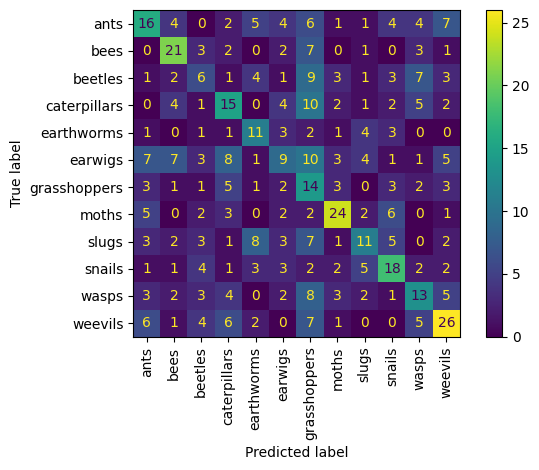

In [11]:
# === Cell 11: Confusion Matrix (TEST) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = sorted(np.unique(np.concatenate([yte, yp_test])))
cm = confusion_matrix(yte, yp_test, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[NAMES[i] for i in labels])
disp.plot(xticks_rotation=90, values_format='d')
plt.tight_layout()
plt.show()


In [ ]:
# === Cell 12: Per-class metrics table (TEST) ===
import pandas as pd
from sklearn.metrics import classification_report

labels = sorted(np.unique(np.concatenate([yte, yp_test])))
target_names = [NAMES[i] for i in labels]

report_dict = classification_report(
    yte, yp_test,
    labels=labels,
    target_names=target_names,
    output_dict=True,
    zero_division=0
)

# 
cls_rows = {k: v for k, v in report_dict.items() if k in target_names}
df_cls = pd.DataFrame(cls_rows).T[['precision','recall','f1-score','support']]

# macro avg / weighted avg / accuracy）
macro_row = report_dict.get('macro avg', {})
weighted_row = report_dict.get('weighted avg', {})
acc_value = report_dict.get('accuracy', None)

print("=== Per-class metrics on TEST ===")
display(df_cls.round(3))

print("\n=== Summary (TEST) ===")
if acc_value is not None:
    print(f"Accuracy: {acc_value:.3f}")
if macro_row:
    print(f"Macro Avg -> P: {macro_row.get('precision', 0):.3f} | "
          f"R: {macro_row.get('recall', 0):.3f} | "
          f"F1: {macro_row.get('f1-score', 0):.3f}")
if weighted_row:
    print(f"Weighted Avg -> P: {weighted_row.get('precision', 0):.3f} | "
          f"R: {weighted_row.get('recall', 0):.3f} | "
          f"F1: {weighted_row.get('f1-score', 0):.3f}")

print("\nWorst classes by F1 (bottom 5):")
display(df_cls.sort_values('f1-score').head(5).round(3))


=== Per-class metrics on TEST ===


,precision,recall,f1-score,support
ants,0.348,0.296,0.320,54.0
bees,0.467,0.525,0.494,40.0
beetles,0.194,0.146,0.167,41.0
caterpillars,0.306,0.326,0.316,46.0
earthworms,0.314,0.407,0.355,27.0
earwigs,0.257,0.153,0.191,59.0
grasshoppers,0.167,0.368,0.230,38.0
moths,0.545,0.511,0.527,47.0
slugs,0.344,0.239,0.282,46.0
snails,0.391,0.409,0.400,44.0



=== Summary (TEST) ===
Accuracy: 0.337
Macro Avg -> P: 0.342 | R: 0.343 | F1: 0.336
Weighted Avg -> P: 0.346 | R: 0.337 | F1: 0.336

Worst classes by F1 (bottom 5):


,precision,recall,f1-score,support
beetles,0.194,0.146,0.167,41.0
earwigs,0.257,0.153,0.191,59.0
grasshoppers,0.167,0.368,0.230,38.0
slugs,0.344,0.239,0.282,46.0
wasps,0.310,0.283,0.295,46.0
